In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/poseidon')
from keras.layers import Input, Reshape, LSTM, RepeatVector, TimeDistributed
from keras.models import Model
from keras import callbacks
import datetime
from scipy import linalg, dot

In [50]:
sample_data = pd.read_csv('sample_simulated_transaction_history.csv')

In [51]:
pd.set_option('display.max_columns', None)

In [52]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [53]:
sample_data.shape

(939512, 11)

In [54]:
sample_data.date = pd.to_datetime(sample_data.date)

In [55]:
def name_trunc(x):
    x = "_".join(x.split("_", 2)[:2])
    return x

In [56]:
sample_data.id = sample_data.id.map(lambda x:name_trunc(x))

In [57]:
df = []
depts = []
for i in sample_data.dept.unique():
    df.append(sample_data[(sample_data.dept == i)].reset_index(drop = True)[['id','date', 'purchaseamount']])
    depts.append(i)

In [58]:
sample_data.isnull().values.any()

False

In [59]:
def obtain_encoding(dataframe, depts, sample_data, pre_end_date, pre_start_date, EPOCHS, BATCH_SIZE, DIM):
    complete_data = pd.DataFrame({'date':pd.date_range(sample_data.date.min(), sample_data.date.max())})
    complete_data.set_index('date', inplace = True)
    for i in dataframe.id.unique():
        specific_donor = dataframe[(dataframe.id == i)].reset_index(drop = True).groupby(['date']).max().drop(labels = ['id'], axis = 1).reindex(pd.date_range(sample_data.date.min(), sample_data.date.max()), fill_value = 0)
        complete_data[i] = pd.DataFrame({i:specific_donor.purchaseamount})

    xtrain = complete_data[pre_start_date:pre_end_date]
    x_train = xtrain.T.values
    xtrain1 = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    encoding_dim1 = DIM*2
    encoding_dim2 = DIM

    inputs = Input(shape=(xtrain1.shape[1],1))
    encoded1 = LSTM(encoding_dim1)(inputs)
    
    encoded2 = Reshape((encoding_dim1, 1))(encoded1)
    encoded2 = LSTM(encoding_dim2)(encoded2)

    decoded1 = Reshape((encoding_dim2,1))(encoded2)
    decoded = LSTM(xtrain1.shape[1])(decoded1)
    decoded = Reshape((xtrain1.shape[1],1))(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded2)

    sequence_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])
    history = sequence_autoencoder.fit(xtrain1, xtrain1, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                  callbacks = [callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto')])

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    plt.savefig('performance-%s.png' % depts)

    encoded_mat = encoder.predict(xtrain1)
    new_df = pd.DataFrame(encoded_mat)
    new_df[new_df<0] = 0
    new_df.insert(loc=0, column='id', value=complete_data.columns.values)

    original = pd.DataFrame(x_train)
    original.insert(loc = 0, column = 'id', value = complete_data.columns.values)

    decoded_mat = sequence_autoencoder.predict(xtrain1)
    decoded_mat = np.reshape(decoded_mat, (decoded_mat.shape[0], decoded_mat.shape[1]))
    comparison_df = pd.DataFrame(decoded_mat)
    comparison_df[comparison_df<0] = 0
    comparison_df.insert(loc = 0, column = 'id', value = complete_data.columns.values)
    
    score = dot(x_train,decoded_mat.T)/linalg.norm(x_train)/linalg.norm(decoded_mat)
    
    return new_df, original, comparison_df, np.linalg.norm(score, ord = 2)

Epoch 1/500
2617/2617 [==============================] - 70s 27ms/step - loss: 451.8373 - mean_absolute_error: 1.2696
Epoch 2/500
2617/2617 [==============================] - 61s 23ms/step - loss: 451.1581 - mean_absolute_error: 1.5934
Epoch 3/500
2617/2617 [==============================] - 61s 23ms/step - loss: 450.6016 - mean_absolute_error: 1.9814
Epoch 4/500
2617/2617 [==============================] - 67s 25ms/step - loss: 450.3815 - mean_absolute_error: 2.1432
Epoch 5/500
2617/2617 [==============================] - 61s 23ms/step - loss: 450.3710 - mean_absolute_error: 2.1558
Epoch 6/500
2617/2617 [==============================] - 62s 24ms/step - loss: 450.3617 - mean_absolute_error: 2.1570
Epoch 7/500
2617/2617 [==============================] - 66s 25ms/step - loss: 450.3550 - mean_absolute_error: 2.1568
Epoch 8/500
2617/2617 [==============================] - 61s 23ms/step - loss: 450.3536 - mean_absolute_error: 2.1555
Epoch 9/500
2617/2617 [==============================] -

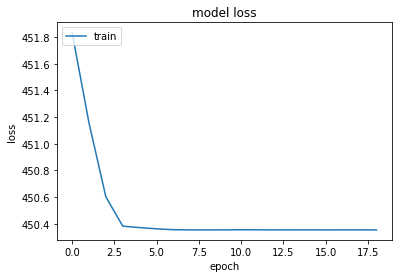

Epoch 1/500
2617/2617 [==============================] - 33s 13ms/step - loss: 3745.2096 - mean_absolute_error: 11.9774
Epoch 2/500
2617/2617 [==============================] - 31s 12ms/step - loss: 3733.8810 - mean_absolute_error: 12.4201
Epoch 3/500
2617/2617 [==============================] - 31s 12ms/step - loss: 3724.8090 - mean_absolute_error: 12.7541
Epoch 4/500
2617/2617 [==============================] - 31s 12ms/step - loss: 3723.3530 - mean_absolute_error: 12.7876
Epoch 5/500
2617/2617 [==============================] - 31s 12ms/step - loss: 3723.3268 - mean_absolute_error: 12.7866
Epoch 6/500
2617/2617 [==============================] - 31s 12ms/step - loss: 3723.3266 - mean_absolute_error: 12.7866
Epoch 7/500
2617/2617 [==============================] - 31s 12ms/step - loss: 3723.3267 - mean_absolute_error: 12.7866
Epoch 8/500
2617/2617 [==============================] - 40s 15ms/step - loss: 3723.3267 - mean_absolute_error: 12.7866
Epoch 9/500
2617/2617 [=================

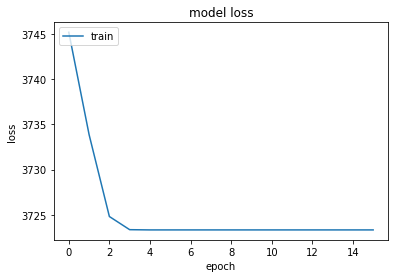

Epoch 1/500
2617/2617 [==============================] - 34s 13ms/step - loss: 45.0447 - mean_absolute_error: 1.6863
Epoch 2/500
2617/2617 [==============================] - 30s 12ms/step - loss: 43.8219 - mean_absolute_error: 2.0819
Epoch 3/500
2617/2617 [==============================] - 40s 15ms/step - loss: 42.9330 - mean_absolute_error: 2.4353
Epoch 4/500
2617/2617 [==============================] - 46s 17ms/step - loss: 42.7820 - mean_absolute_error: 2.4986
Epoch 5/500
2617/2617 [==============================] - 46s 18ms/step - loss: 42.7742 - mean_absolute_error: 2.5010
Epoch 6/500
2617/2617 [==============================] - 46s 18ms/step - loss: 42.7712 - mean_absolute_error: 2.5024
Epoch 7/500
2617/2617 [==============================] - 47s 18ms/step - loss: 42.7709 - mean_absolute_error: 2.5026
Epoch 8/500
2617/2617 [==============================] - 46s 18ms/step - loss: 42.7709 - mean_absolute_error: 2.5026
Epoch 9/500
2617/2617 [==============================] - 47s 18m

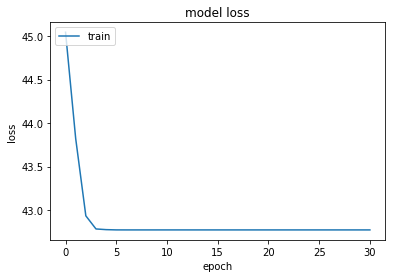

Epoch 1/500
2617/2617 [==============================] - 50s 19ms/step - loss: 21.8898 - mean_absolute_error: 0.3793
Epoch 2/500
2617/2617 [==============================] - 45s 17ms/step - loss: 21.8026 - mean_absolute_error: 0.6730
Epoch 3/500
2617/2617 [==============================] - 47s 18ms/step - loss: 21.7656 - mean_absolute_error: 0.8225
Epoch 4/500
2617/2617 [==============================] - 46s 18ms/step - loss: 21.7496 - mean_absolute_error: 0.7637
Epoch 5/500
2617/2617 [==============================] - 46s 18ms/step - loss: 21.7485 - mean_absolute_error: 0.7223
Epoch 6/500
2617/2617 [==============================] - 46s 18ms/step - loss: 21.7482 - mean_absolute_error: 0.7250
Epoch 7/500
2617/2617 [==============================] - 45s 17ms/step - loss: 21.7457 - mean_absolute_error: 0.7352
Epoch 8/500
2617/2617 [==============================] - 45s 17ms/step - loss: 21.7449 - mean_absolute_error: 0.7341
Epoch 9/500
2617/2617 [==============================] - 47s 18m

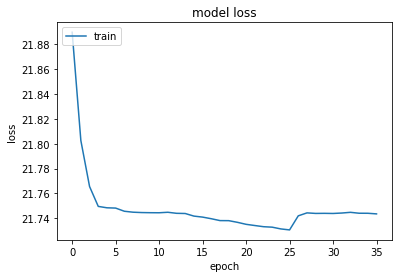

Epoch 1/500
2617/2617 [==============================] - 51s 20ms/step - loss: 124.8034 - mean_absolute_error: 0.8783
Epoch 2/500
2617/2617 [==============================] - 46s 17ms/step - loss: 124.3875 - mean_absolute_error: 1.2533
Epoch 3/500
2617/2617 [==============================] - 46s 17ms/step - loss: 124.1405 - mean_absolute_error: 1.5448
Epoch 4/500
2617/2617 [==============================] - 44s 17ms/step - loss: 124.0775 - mean_absolute_error: 1.6633
Epoch 5/500
2617/2617 [==============================] - 40s 15ms/step - loss: 124.0644 - mean_absolute_error: 1.6638
Epoch 6/500
2617/2617 [==============================] - 31s 12ms/step - loss: 124.0594 - mean_absolute_error: 1.6382
Epoch 7/500
2617/2617 [==============================] - 31s 12ms/step - loss: 124.0590 - mean_absolute_error: 1.6339
Epoch 8/500
2617/2617 [==============================] - 31s 12ms/step - loss: 124.0572 - mean_absolute_error: 1.6425
Epoch 9/500
2617/2617 [==============================] -

2617/2617 [==============================] - 24s 9ms/step - loss: 123.9991 - mean_absolute_error: 1.6510
Epoch 71/500
2617/2617 [==============================] - 24s 9ms/step - loss: 123.9956 - mean_absolute_error: 1.6542
Epoch 72/500
2617/2617 [==============================] - 24s 9ms/step - loss: 123.9958 - mean_absolute_error: 1.6530
Epoch 73/500
2617/2617 [==============================] - 24s 9ms/step - loss: 123.9905 - mean_absolute_error: 1.6453
Epoch 74/500
2617/2617 [==============================] - 24s 9ms/step - loss: 123.9936 - mean_absolute_error: 1.6281
Epoch 75/500
2617/2617 [==============================] - 24s 9ms/step - loss: 123.9876 - mean_absolute_error: 1.6442
Epoch 76/500
2617/2617 [==============================] - 24s 9ms/step - loss: 123.9877 - mean_absolute_error: 1.6224
Epoch 77/500
2617/2617 [==============================] - 24s 9ms/step - loss: 123.9841 - mean_absolute_error: 1.6411
Epoch 78/500
2617/2617 [==============================] - 24s 9ms/ste

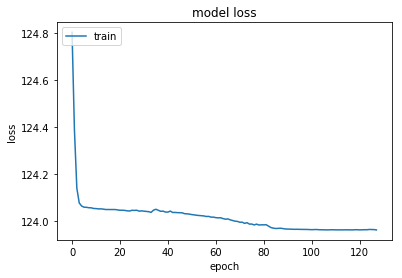

Epoch 1/500
2617/2617 [==============================] - 27s 10ms/step - loss: 1952.5382 - mean_absolute_error: 4.3591
Epoch 2/500
2617/2617 [==============================] - 24s 9ms/step - loss: 1949.1752 - mean_absolute_error: 4.7921
Epoch 3/500
2617/2617 [==============================] - 24s 9ms/step - loss: 1946.2093 - mean_absolute_error: 5.1265
Epoch 4/500
2617/2617 [==============================] - 24s 9ms/step - loss: 1945.4262 - mean_absolute_error: 5.1884
Epoch 5/500
2617/2617 [==============================] - 24s 9ms/step - loss: 1945.3507 - mean_absolute_error: 5.1896
Epoch 6/500
2617/2617 [==============================] - 24s 9ms/step - loss: 1945.3316 - mean_absolute_error: 5.1921
Epoch 7/500
2617/2617 [==============================] - 24s 9ms/step - loss: 1945.3308 - mean_absolute_error: 5.1922
Epoch 8/500
2617/2617 [==============================] - 24s 9ms/step - loss: 1945.3307 - mean_absolute_error: 5.1922
Epoch 9/500
2617/2617 [==============================] 

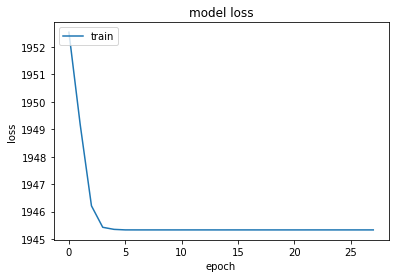

In [60]:
encod = []
original = []
compare = []
score = []
pre_start_date = '2015-01-01'
pre_end_date = '2016-01-01'
for i in range(len(df)):
    alpha, beta, gamma, delta = obtain_encoding(df[i], depts[i], sample_data, pre_end_date, pre_start_date, EPOCHS=500, BATCH_SIZE=500, DIM=50)
    encod.append(alpha)
    original.append(beta)
    compare.append(gamma)
    score.append(delta)
    encod[-1].to_csv('encoding_of_%s_customers.csv' %depts[i], index = False)
    original[-1].to_csv('original_of_%s_customers.csv' %depts[i], index = False)
    compare[-1].to_csv('comparison_of_%s_customers.csv' %depts[i], index = False)

In [61]:
print('Mean cosine distance:', np.mean(score))

Mean cosine distance: 0.5118152387534813
